# Creating the IOOS Asset Inventory

This notebook walks through the process for creating the asset inventory from the spreadsheets collected from the Regional Associations.

First we need to import some libraries and enable KML support.

In [1]:
import fiona
import geopandas
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

Now we identify the directory where the excel spreadsheets are found. This should be edited to correspond with the appropriate year and file type to be processed.

In [2]:
year = '2021'
dir = year+'/data/processed/'
all_files = os.listdir(dir)

regex = re.compile(r'~.*')

files = [i for i in all_files if not regex.match(i)]

print('Found %i Excel workbooks' % len(files))

Found 11 Excel workbooks


Now start building the pandas DataFrame to capture the information in the spreadsheets. We do some minor cleaning here, including:
 * dropping empty rows
 * removing special characters
 * adding RA column if spreadsheet doesn't have it

In [3]:
df_raw = pd.DataFrame(
    columns=['RA', 'Station ID', 'WMO ID or NWS/CMAN ID', 'Station Long Name',
       'Station Description', 'Latitude (dec deg)', 'Longitude (dec deg)',
       'Platform Type', 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)',
       'Currently Operational? (Y, N, O, U)', 'Platform Funder/Sponsor',
       'RA Funding Involvement (Yf, Yp, N)', 'Platform Operator/Owner',
       'Operator Sector', 'Platform Maintainer', 'Data Manager',
       'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].',
       'Additional notes', 'file']
)
for file in files:
    fname = dir + file

    print('Reading %s' % file)
    df = pd.read_excel(fname, header=0)

    # Drop empty rows
    df.dropna(axis='index', how='all', inplace=True)
    # Removing special chars
    df.replace('\xa0', '', regex=True, inplace=True)
    df.replace('\n','', regex=True, inplace=True) # remove carriage returns

    # create RA column if missing
    if 'RA' not in df.columns:
        df['RA'] = file.split(".")[0]

    # add the file name for use later
    df['file'] = file

    # concatenate data frames into one mongo DF.
    df_raw = pd.concat([df_raw, df], ignore_index=True)

    # print some information out
    print('Ingested %s with %i columns' % (file, len(df.columns)))

print('Initial row count: %i' % df_raw.shape[0])

Reading AOOS.xlsx
Ingested AOOS.xlsx with 19 columns
Reading CARICOOS.xlsx
Ingested CARICOOS.xlsx with 21 columns
Reading CeNCOOS.xlsx
Ingested CeNCOOS.xlsx with 19 columns
Reading GCOOS.xlsx
Ingested GCOOS.xlsx with 19 columns
Reading GLOS.xlsx
Ingested GLOS.xlsx with 18 columns
Reading MARACOOS.xlsx
Ingested MARACOOS.xlsx with 20 columns
Reading NANOOS.xlsx
Ingested NANOOS.xlsx with 19 columns
Reading NERACOOS.xlsx
Ingested NERACOOS.xlsx with 19 columns
Reading PACIOOS.xlsx


C:\Users\Mathew.Biddle\programs\Miniforge\envs\ioos-asset-inventory\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Ingested PACIOOS.xlsx with 19 columns
Reading SCCOOS.xlsx
Ingested SCCOOS.xlsx with 19 columns
Reading SECOORA.xlsx
Ingested SECOORA.xlsx with 19 columns
Initial row count: 520


Let's clean up the headers for the source data.

In [4]:
columns = {
       'Station ID': 'Station_ID', 
       'WMO ID or NWS/CMAN ID': 'WMO_CMAN_ID', 
       'Station Long Name': 'Station_Long_Name',
       'Station Description': 'Station_Description', 
       'Latitude (dec deg)': 'Latitude', 
       'Longitude (dec deg)': 'Longitude',
       'Platform Type': 'Platform_Type', 
       'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station_Deployment',
       'Currently Operational? (Y, N, O, U)': 'Currently_Operational', 
       'Platform Funder/Sponsor': 'Platform_Funder',
       'RA Funding Involvement (Yf, Yp, N)':'RA_Funded', 
       'Platform Operator/Owner': 'Platform_Operator',
       'Operator Sector': 'Operator_Sector', 
       'Platform Maintainer': 'Platform_Maintainer', 
       'Data Manager':'Data_Manager',
       'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].': 'Variable_Names',
       'Additional notes': 'Additional_notes',
}

df_raw.rename(columns=columns, inplace=True)

df_raw

,RA,Station_ID,WMO_CMAN_ID,Station_Long_Name,Station_Description,Latitude,Longitude,Platform_Type,Station_Deployment,Currently_Operational,...,Platform_Maintainer,Data_Manager,Variable_Names,Additional_notes,file,CARICOOS Contact (Name and Email),RA/Federal Affiliation,Dataset ID,Unnamed: 15,Unnamed: 18
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,...,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...,AOOS.xlsx,NaN,NaN,NaN,NaN,NaN
1,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,...,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...,AOOS.xlsx,NaN,NaN,NaN,NaN,NaN
2,AOOS,urn:ioos:station:org.mxak:AKUTAN_WX,NaN,"Akutan, Port",WEATHER (no AIS); AIS LOCATED AT DIFFERENT SPOT,54.1321,-165.7818,Fixed,06/14/17; 7/26/2017,Y,...,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",need to cross check station,AOOS.xlsx,NaN,NaN,NaN,NaN,NaN
3,AOOS,urn:ioos:station:org.mxak:ANCHORAGE_PORT,NaN,Anchorage Port,AIS TRANSCEIVER WITH WEATHER,61.238746,-149.888778,Fixed,2015-05-05 00:00:00,Y,...,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,AOOS.xlsx,NaN,NaN,NaN,NaN,NaN
4,AOOS,org_mxak_bethel,NaN,Bethel,Weather (not sure if there is AIS there),60.7915,-161.7487,Fixed,2019-12-28 00:00:00,Y,...,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",New in 2019 but AOOS not reporting until 2020,AOOS.xlsx,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,SECOORA,IRL-SLE,NaN,Indian River Lagoon - St. Lucie Estuary,IRL water quality,27.1649,-80.1718,moored_buoy,> 5 yr,Y,...,FAU,FAU,"sea_water_temperature, air_temperatue, relativ...",Information on stations: www.irlon.org and htt...,SECOORA.xlsx,NaN,NaN,NaN,NaN,NaN
516,SECOORA,SLE-NF,NaN,St. Lucie Estuary - North Fork,SLE water quality,27.21,-80.2692,moored_buoy,> 5 yr,Y,...,FAU,FAU,"sea_water_temperature, air_temperatue, relativ...",Information on stations: www.irlon.org and htt...,SECOORA.xlsx,NaN,NaN,NaN,NaN,NaN
517,SECOORA,SLE-SF,NaN,St. Lucie Estuary - South Fork,SLE water quality,27.1878,-80.2642,moored_buoy,> 5 yr,Y,...,FAU,FAU,"sea_water_temperature, air_temperatue, relativ...",Information on stations: www.irlon.org and htt...,SECOORA.xlsx,NaN,NaN,NaN,NaN,NaN
518,SECOORA,SLE-ME,NaN,St. Lucie Estuary - Middle Estuary,SLE water quality,27.2089,-80.248,moored_buoy,> 5 yr,Y,...,FAU,FAU,"sea_water_temperature, air_temperatue, relativ...",Information on stations: www.irlon.org and htt...,SECOORA.xlsx,NaN,NaN,NaN,NaN,NaN


Now we need to do a little cleaning to remove platform types that shouldn't be part of the inventory. So, we create a copy of the dataFrame for processing and remove the rows that have platforms of `surface_current_radar` and `glider`.

In [5]:
df_all = df_raw.copy()

df_all['RA'] = df_all['RA'].astype(str).str.strip()

print('Removing platform type = \'surface_current_radar\' | \'glider\'.')
df_all.drop(
    df_all.loc[
        (df_all['Platform_Type'] == 'surface_current_radar') |
        (df_all['Platform_Type'] == 'glider')
    ].index,
    inplace=True)
print('row count:', df_all.shape[0])

Removing platform type = 'surface_current_radar' | 'glider'.
row count: 520


Convert lat/lon to floating points.

In [6]:
#df_all.drop(
#    df_all.loc[df_all['Latitude (dec deg)'] == '(Required) '].index,
#    inplace=True)

In [7]:
#df_all.loc[df_all['Latitude (dec deg)'] == '35 15.555', ['file']]

In [8]:
df_all[['Latitude', 'Longitude']] = df_all[['Latitude', 'Longitude']].astype(float)

Find all bad coordinates and tell me which file they belong to and what the coordinates are.

In [9]:
df_all.loc[(df_all['Longitude']<-180) | (df_all['Longitude'] > 180) | (df_all['Latitude'] > 90) | (df_all['Latitude'] < -90), ['Latitude','Longitude','file']]

,Latitude,Longitude,file


In [10]:
df_all['RA_Funded'].unique()

array(['Yp', 'N', 'Yf', 'Y', 'YP',
       'N (install, OnM);  Y  (AOOS paid for conversion of GNSS-R data for Water Level)',
       'Yf (AOOS funded the installation); Yp UNAVCO is payin for data filtration costs',
       'yp', 'n', nan], dtype=object)

In [11]:
df_all['Currently_Operational'].unique()

array(['Y', 'y', 'O  ', 'O', 'Y, O (seasonal)', 'Operational', nan, 'o',
       'Y till 2018', 'N to Y', 'U to Y', 'Y to O', 'O to Y', 'N',
       'U - no longer funded '], dtype=object)

In [12]:
df_all.loc[df_all['RA_Funded'].isna()]

,RA,Station_ID,WMO_CMAN_ID,Station_Long_Name,Station_Description,Latitude,Longitude,Platform_Type,Station_Deployment,Currently_Operational,...,Platform_Maintainer,Data_Manager,Variable_Names,Additional_notes,file,CARICOOS Contact (Name and Email),RA/Federal Affiliation,Dataset ID,Unnamed: 15,Unnamed: 18
130,CeNCOOS,Morro Back Bay,N/A recent station,Morro Back Bay BS1,Morro Back Bay BS1,35.33382,-120.84725,fixed pier,2018-09-20 00:00:00,y,...,Cal Poly,Cal Poly,"sea_water_temperature(1m), sea_water_pressure(...",NaN,CeNCOOS.xlsx,NaN,NaN,NaN,NaN,NaN


Saving dates as strings

In [13]:
df_all['Station_Deployment'] = \
    df_all['Station_Deployment'].astype(str)

Make a simple plot of station locations

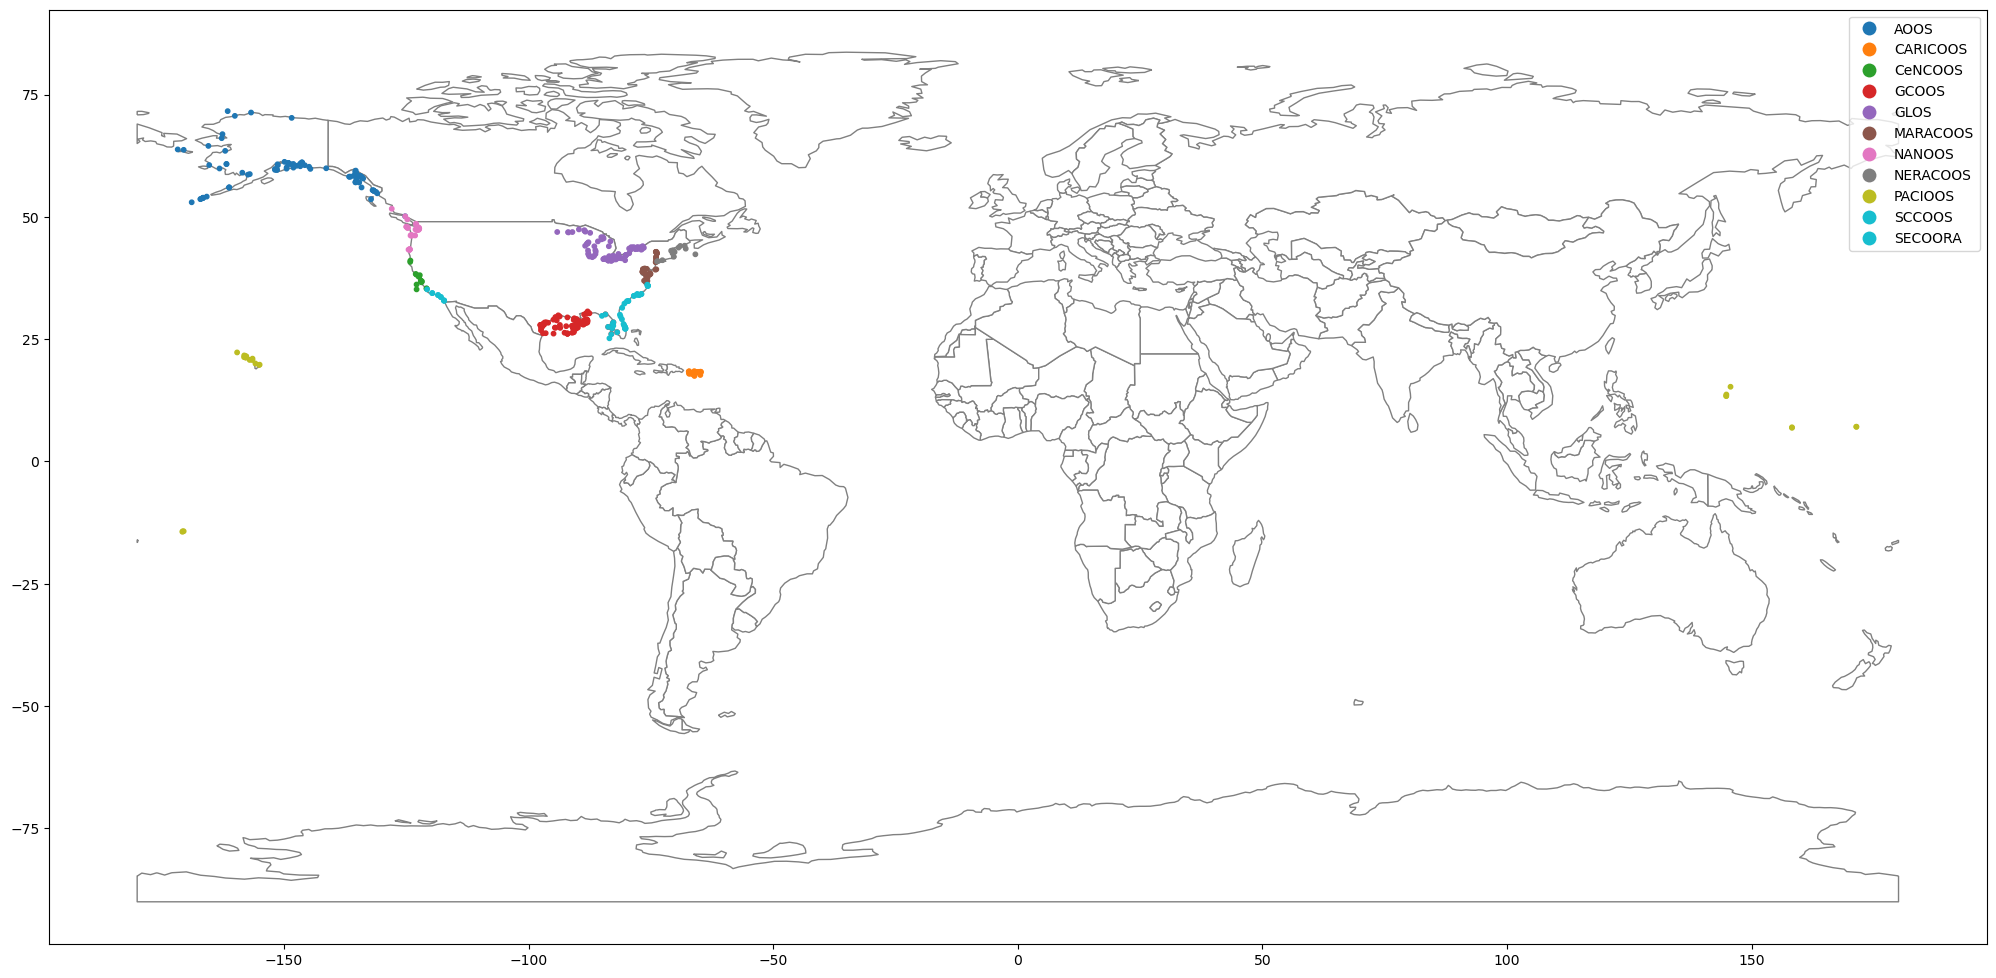

In [14]:
gdf = geopandas.GeoDataFrame(
    df_all, geometry=geopandas.points_from_xy(df_all['Longitude'], df_all['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot(ax=ax, 
         column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )

plt.show()

Create a final DataFrame for processed file

In [15]:
df_final = pd.DataFrame(columns=
                        ['RA','Latitude','Longitude','Platform','Operational',
                         'RA_Funded','Water_temp','Salinity','Wtr_press',
                         'Dew_pt','Rel_hum','Air_temp','Winds','Air_press',
                         'Precip','Solar_radn','Visibility','Water_level','Waves',
                         'Currents','Turbidity','DO','pCO2_water','pCO2_air','TCO2',
                         'pH','OmgArag_st','Chl','Nitrate','CDOM','Alkalinity','Acoustics','file'])

df_final['RA'] = df_all['RA']
df_final['station_long_name'] = df_all['Station_Long_Name']
df_final['Latitude'] = df_all['Latitude']
df_final['Longitude'] = df_all['Longitude']
df_final['Platform'] = df_all['Platform_Type']
df_final['Operational'] = df_all['Currently_Operational']
df_final['station_deployment'] = df_all['Station_Deployment']
df_final['RA_Funded'] = df_all['RA_Funded']
df_final['Raw_Vars'] = df_all['Variable_Names']
df_final['file'] = df_all['file']

Map provided variable text to standard vars and platforms to consistent platform categories

In [16]:
import utils.mapping

df_final = utils.mapping.variables(df_final, df_all)
df_final = utils.mapping.platforms(df_final)

Reorganize the DataFrame

In [17]:
cols = ['RA', 'Latitude', 'Longitude', 'station_long_name', 'Platform', 'Operational', 'station_deployment', 
        'RA_Funded', 'Water_temp', 'Salinity', 'Wtr_press', 'Dew_pt', 'Rel_hum', 'Air_temp',
        'Winds', 'Air_press', 'Precip', 'Solar_radn', 'Visibility',
        'Water_level', 'Waves', 'Currents', 'Turbidity', 'DO', 'pCO2_water',
        'pCO2_air', 'TCO2', 'pH', 'OmgArag_st', 'Chl', 'Nitrate', 'CDOM',
        'Alkalinity', 'Acoustics', 'Raw_Vars','file']
df_final = df_final[cols]

Create a geopandas DataFrame.

In [18]:
gdf_final = geopandas.GeoDataFrame(
    df_final, geometry=geopandas.points_from_xy(df_final['Longitude'], df_final['Latitude']))

Write data files.

In [19]:
print('Saving inventory files...')
# csv
df_raw.to_csv(year+'/combined_raw_inventory.csv', index=False)
df_final.drop(labels='geometry', axis='columns', inplace=True)
df_final.to_csv(year+'/processed_inventory.csv', index=False)

# geojson
gdf.to_file(year+'/combined_raw_inventory.geojson', driver='GeoJSON')
gdf_final.to_file(year+'/processed_inventory.geojson', driver='GeoJSON')

# kml
gdf.to_file(year+'/combined_raw_inventory.kml', driver='LIBKML')
gdf_final.to_file(year+'/processed_inventory.kml', driver='LIBKML')

Saving inventory files...


In [20]:
gdf_final = gdf_final.set_crs(epsg=4326)

gdf_final.loc[gdf_final['geometry'].is_empty == False].explore("RA",categorical=True, tooltip=33, tiles="CartoDB dark_matter")

Find empty coordinates

In [21]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Latitude,Longitude,station_long_name,Platform,Operational,station_deployment,RA_Funded,Water_temp,Salinity,...,pH,OmgArag_st,Chl,Nitrate,CDOM,Alkalinity,Acoustics,Raw_Vars,file,geometry


Doing some digging

In [22]:
# df_all.loc[
#     (df_all['RA']=='SECOORA') & (df_all['Currently Operational? (Y, N, O, U)']=='Y'),
#     ['Station ID','Station Description','WMO ID or NWS/CMAN ID','Latitude','Longitude','RA Funding Involvement (Yf, Yp, N)','Currently Operational? (Y, N, O, U)','Additional notes']
# ]

# Save map image

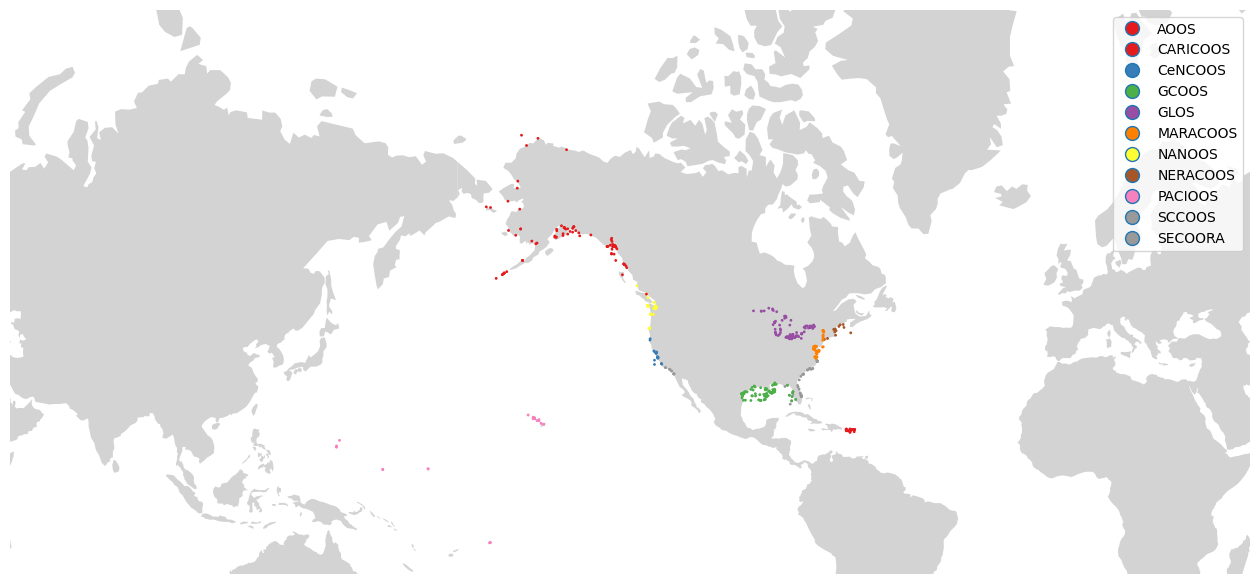

In [23]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

#projection=gcrs.Mollweide(central_longitude=-130)
projection = gcrs.Mercator(central_longitude=-130)


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world.dissolve(),
    #world,
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

# cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

#cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.pointplot(gdf_final, 
                   hue='RA', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Set1',
                   legend=True,
                   scale='Latitude',
                   limits=(1,1),
                   legend_var='hue',
#                    legend_kwargs={'orientation': 'horizontal',
#                                   'cax':cax,
#                                   'label':"occurrence (count)",
#                                  },
                 #  norm=norm, 
                  )

#ax.set_global(); 

#ax.outline_patch.set_visible(True)

# or define your own as a list [xmin, xmax, ymin, ymax]
# extent = [gdf_final['Latitude'].min(), gdf_final['Latitude'].max(), gdf_final['Longitude'].max(), gdf_final['Longitude'].min()]

# ax.set_extent(extent)

plt.savefig(year+'/station_location_map.jpg')